[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


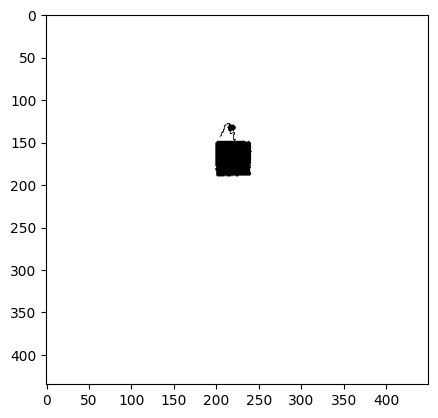

In [271]:
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from skimage import color
from skimage import io

# Load image
img_gray = np.array(255 * color.rgb2gray(io.imread('specks3.jpg')), np.uint8)

img_patch = np.copy(img_gray)
img_patch[150:190, 200:240] = 0

# Use edge detector to find missing patch automatically
edges = cv2.Canny(img_patch, 100, 200)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.imwrite('edge.jpg', edges)

max_area = 0.0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
        max_area = area
        max_index = cnt # Get pixel positions of white edges, max_index is an array of x,y coord

# Zero out the patch from the image
mask = np.zeros_like(img_gray)
pts = np.array([[max_index[i][0][0], max_index[i][0][1]] for i in range(len(max_index))], np.int32)

cv2.fillPoly(mask, [pts], 1) #fill in the patch
mask = mask.astype(bool) # mask is a binary matrix

print(mask)
plt.imshow(np.invert(mask), cmap='gray')
plt.savefig('mask.jpg')

435
90.0


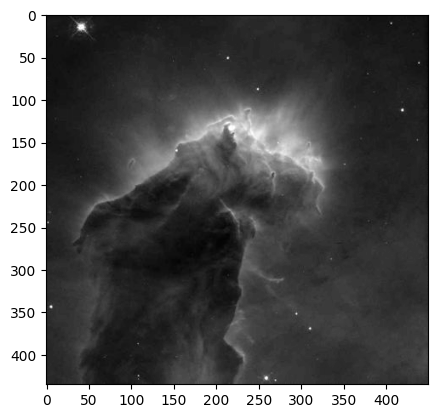

In [2]:
# Low-rank matrix completion
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib import image
from numpy.linalg import matrix_rank
from PIL import Image, ImageFilter
from skimage import color
from skimage import io

# Create the ground truth image of my initial SK
# Feel free to uncomment the following lines to test with a simpler input image
# Xtrue = np.matrix('0 0 0 0 0 0 0 0 0 0 0 0; \
#                    0 0 1 1 0 0 0 1 0 1 0 0; \
#                    0 1 0 0 1 0 0 1 1 0 0 0; \
#                    0 0 1 0 0 0 0 1 0 0 0 0; \
#                    1 0 0 1 0 0 0 1 1 0 0 0; \
#                    0 1 1 0 0 0 0 1 0 1 0 0; \
#                    0 0 0 0 0 0 0 0 0 0 0 0')
# Xtrue = np.kron(10 + 80*Xtrue, np.ones((9, 9)))

Xtrue = 10 + 80 * color.rgb2gray(io.imread('specks3.jpg'))
plt.imshow(Xtrue, cmap='gray')
print(matrix_rank(Xtrue)) # rank = 435
print(np.amax(Xtrue))


(435, 450)
psnr of the corrupted image: 25.038131666954282


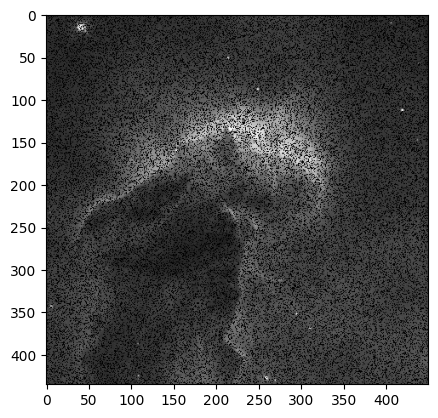

In [3]:
np.random.seed(0) # set seed to 0
M = np.random.rand(*Xtrue.shape).astype(np.float32) >= 0.25 # 75% missing
# M = np.invert(mask) // uncomment this line for Mask A
plt.imshow(np.invert(M), cmap='gray')
print(M.shape)
Y = np.multiply(M, (Xtrue + np.random.randn(*Xtrue.shape))) # np.multiply is element-wise multiplication
plt.imshow(Y, cmap='gray')
print('psnr of the corrupted image:', cv2.PSNR(Y, Xtrue))
plt.savefig('Y.jpg')

In [4]:
# Optimization routine
from numpy.linalg import norm
from scipy.linalg import svdvals

# Define cost function for optimization problem
def nucnorm(X):
    return np.sum(svdvals(X)) # nuclear norm

def costfunc_ista(X, beta):
    return 0.5 * norm(X[M] - Y[M])**2 + beta * nucnorm(X) # regularized cost
# square of Frobenius norm of a matrix = square of L2 norm of singular values for the matrix

In [5]:
# Formulate soft thresholding function
from scipy.linalg import svd
def SVST(X, beta):
    u, s, vh = svd(X, full_matrices=False) # s is singular value (first do eigenvalue decomp)
    sthresh = np.maximum(s - beta, 0) # for s<beta, they are set to 0 -> more singular values are set to zero making the matrices more sparse
    return u @ np.diag(sthresh) @ vh

In [ ]:
# Iterative Soft-Thresholding Algorithm (ISTA)
iterNum = 400
X = np.copy(Y)
Xold = np.copy(X)
beta = 0 # random
cost_ista = np.zeros(iterNum+1)
cost_ista[0] = costfunc_ista(X,beta)
for k in range(iterNum):
    X = np.multiply(np.invert(M), X) + np.multiply(M, Y)
    X = SVST(X,beta) 
    cost_ista[k+1] = costfunc_ista(X,beta)
print(X.shape)
print('psnr of the recovered image:', cv2.PSNR(X, Xtrue))

In [ ]:
plt.imshow(X, cmap = 'gray')

In [7]:
# Fast Iterative Soft-Thresholding Algorithm (FISTA)
iterNum = 125
X = np.copy(Y)
Z = np.copy(X)
Xold = np.copy(X)
t_old = 1
beta = 5 # random
cost_fista = np.zeros(iterNum+1)
cost_fista[0] = costfunc_ista(X,beta)
for k in range(iterNum):
    Z = np.multiply(np.invert(M), Z) + np.multiply(M, Y)
    X = SVST(Z,beta) 
    t = (1 + np.sqrt(1 + 4 * (t_old**2))) / 2
    Z = X + ((t_old - 1) / t) * (X - Xold)
    Xold = np.copy(X)
    t_old = t
    cost_fista[k+1] = costfunc_ista(X,beta)
print(X.shape)
print('psnr of the recovered image:', cv2.PSNR(X, Xtrue))

(435, 450)
psnr of the recovered image: 47.777261561590976


310


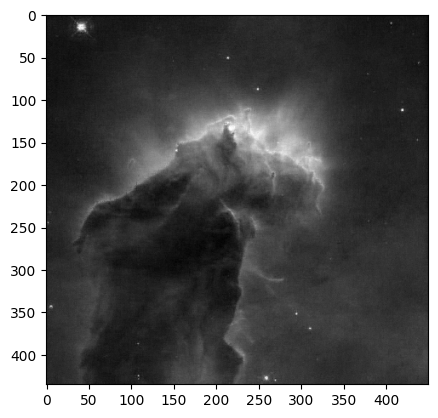

In [8]:
plt.imshow(X, cmap='gray')
plt.savefig('fista.jpg')
print(matrix_rank(X))

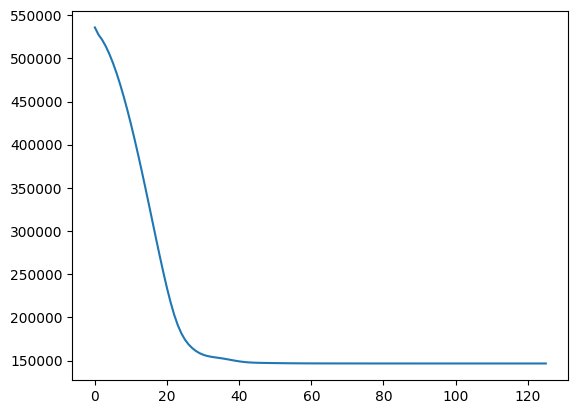

In [9]:
# Visualize the converging trend of the gradient descent and adjust regularization parameter accordingly
plt.plot(cost_fista)

In [289]:
def costfunc_dict(X, D, Z, beta, alpha):
    return 0.5 * norm(X[M] - Y[M])**2 + beta * (1/2 * (norm(X - np.matmul(D,Z))**2) + alpha * norm(Z.flatten(), 1)) # regularized cost

def soft(a, b):
    if a>b:
        return a-b
    elif a<-b:
        return a+b
    else:
        return 0
vsoft = np.vectorize(soft)

In [313]:
# Sparse Dictionary Algorithm
# X and Z have same dimension and D is a square matrix with first dimension of X
from scipy.fftpack import dct

D = dct(np.eye(X.shape[0]), axis=0, norm="ortho")
iterNum = 400
X = np.copy(Y)
Z = np.matmul(D.T, X)
beta = 2 # random
alpha = 2
cost_dict = np.zeros(iterNum+1)
cost_dict[0] = costfunc_dict(X, D, Z, beta, alpha)

for k in range(iterNum):
    X = 1/(beta/2+1) * (np.multiply(np.invert(M), X) + np.multiply(M, Y) + beta/2*np.matmul(D, Z))
    Z = vsoft(np.matmul(D.T, X), alpha)
    cost_dict[k+1] = costfunc_dict(X, D, Z, beta, alpha)


psnr of the recovered image: 43.02171368605307


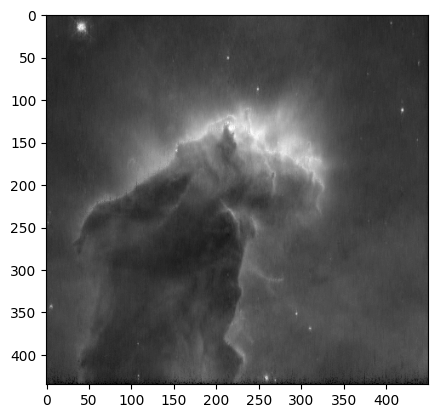

In [314]:
print('psnr of the recovered image:', cv2.PSNR(X, Xtrue))
plt.imshow(X, cmap='gray')
plt.savefig('dct.jpg')

In [315]:
# Sparse Transformation Algorithm
import pywt
def soft_detail(coeffs, alpha):
    # start doing at level 1
    for i in range(1, len(coeffs)):
        coeffs[i] = list(coeffs[i])
        for j in range(len(coeffs[i])):
            # print(vsoft(coeffs[i][j], alpha).dtype)
            coeffs[i][j] = vsoft(coeffs[i][j], alpha)
        coeffs[i] = tuple(coeffs[i])
    return coeffs

def T(x):
    coeffs = pywt.wavedec2(x, 'haar')
    return coeffs
def T_t(c):
    return pywt.waverec2(c, 'haar')

In [316]:
iterNum = 200

X = np.copy(Y)
beta = 5 # random
alpha = 3

for k in range(iterNum):
    # cA is DC term, we only care about the sparsity of cD
    coeffs = soft_detail(T(X), alpha)
    X = (beta * T_t(coeffs)[:435,:] + 2 * (np.multiply(np.invert(M), X) + np.multiply(M, Y))) / (2 + beta)
    


psnr of the recovered image: 42.864990608891624


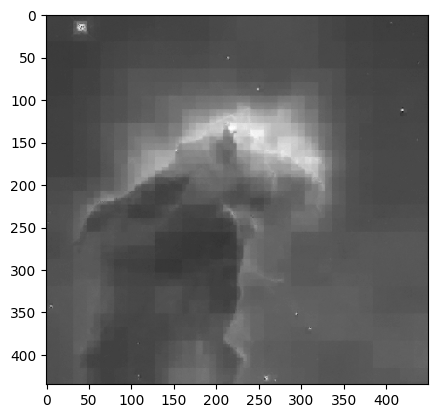

In [317]:
print('psnr of the recovered image:', cv2.PSNR(X, Xtrue))
plt.imshow(X, cmap='gray')
plt.savefig('odwt.jpg')

In [8]:
# Computing the PSNR for GAN
import cv2
from skimage import color
from skimage import io

true = cv2.imread('/Users/soniakim/Desktop/EECS 351/gan_astro_example/myastropicture.png', cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(true, (256, 256)) 

corrupted = cv2.imread('/Users/soniakim/Desktop/EECS 351/gan_astro_example/corrupt.png', cv2.IMREAD_GRAYSCALE)
repainted = cv2.imread('/Users/soniakim/Desktop/EECS 351/gan_astro_example/output.png', cv2.IMREAD_GRAYSCALE)

print('psnr of the corrupted using GAN:', cv2.PSNR(corrupted, resized_image))
print('psnr of the repainted using GAN:', cv2.PSNR(repainted, resized_image))

psnr of the corrupted using GAN: 27.038335487730265
psnr of the repainted using GAN: 30.238446378888337


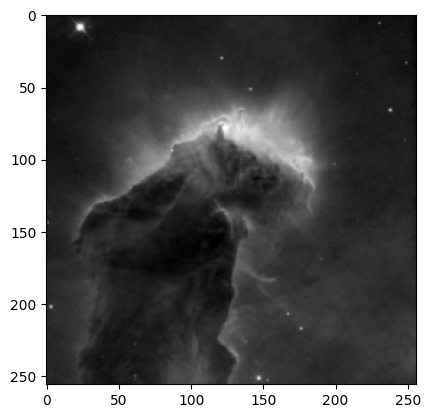

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(repainted, cmap='gray')
plt.show()

In [23]:
# Computing the PSNR for DDPM
import cv2
from skimage import color
from skimage import io

true = cv2.imread('/Users/soniakim/Desktop/EECS 351/ddpm_astro_example/gt/000000.png', cv2.IMREAD_GRAYSCALE)

corrupted = cv2.imread('/Users/soniakim/Desktop/EECS 351/ddpm_astro_example/gt_masked/000000.png', cv2.IMREAD_GRAYSCALE)
repainted = cv2.imread('/Users/soniakim/Desktop/EECS 351/ddpm_astro_example/inpainted/000007.png', cv2.IMREAD_GRAYSCALE)

print('psnr of the corrupted using DDPM:', cv2.PSNR(corrupted, resized_image))
print('psnr of the repainted using DDPM:', cv2.PSNR(repainted, resized_image))

psnr of the corrupted using DDPM: 19.735670518679203
psnr of the repainted using DDPM: 27.167334082160455


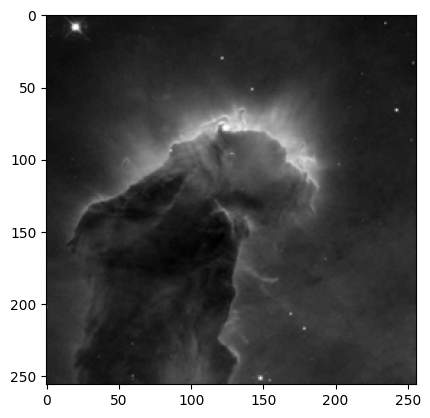

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(repainted, cmap='gray')
plt.show()